<a href="https://colab.research.google.com/github/Untick/Selector_ObjDet/blob/Roman-Penzov-folder/%D0%A1%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_%D0%A0%D0%BE%D0%BC%D0%B0%D0%BD_%D0%9F%D0%B5%D0%BD%D0%B7%D0%BE%D0%B2_%D0%A8%D0%90%D0%93_2_26_05_23_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ШАГ 2.**
Мысли нарастающим итогом:
1.   Как и на шаге 1 для первоначального решения задачи не стал вычищать базу, а оставил только файлы формата jpg и jpeg. Некоторые папки (виды одежды) удалил целиком. А уже на заключительных шагах буду использовать "исправленную/актуализированную" базу.
2.   Также хочу пробовать следующий алгоритм:
  *   сначала первая нейронка должна определить категорию одежды, к которой относится"картинка клиента". И почему бы для этого не использовать для первого варианта обычные сверточные нейронные сети. Иначе возможно попробовать вариант проверки на выброс.
  *   второй вид нейронки - это вариационный автокодировщик, который надо реализовать для каждой категории отдельно. Почему то думается, что так проще и эффективнее.


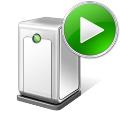

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Lambda, MaxPooling2D, UpSampling2D, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from skimage.transform import resize
# Импорт модуля для работы с архивами
import zipfile

In [ ]:
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Путь к архивному файлу
file_path = '/content/gdrive/MyDrive/test_230501.zip'

# Путь к директории, в которую нужно разархивировать файл
extract_path = '/content/selector'

In [ ]:
# Разархивирование файла
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/selector/test_230501/'

# Получение списка папок, находящихся по адресу в скобках
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 9, метки классов: ['dress  business', 'dress casual', 'dress homemade', 'dress solemn', 'shirt men', 'shirt women', 'sportswear women', 't-shirt men', 't-shirt women']


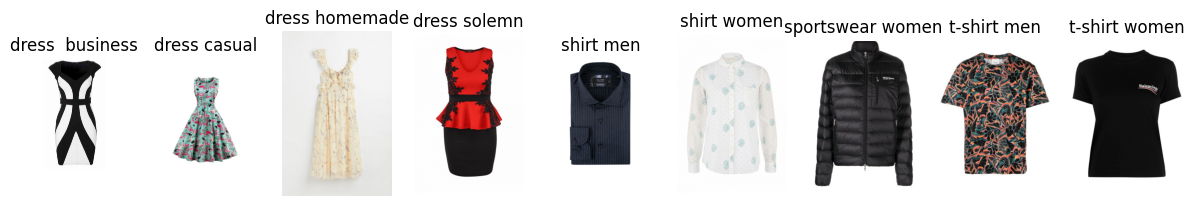

In [ ]:
# Отобразим визуально для примера по одному изображению из каждого класса
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(15, 15))

# Для всех номеров классов:
for i in range(CLASS_COUNT):
    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'
    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path)) 
    # Отображение фотографии
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))  
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [ ]:
# Загрузка и предобработка изображений из базы данных
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = image.load_img(
            os.path.join(folder, filename),
            target_size=(128, 128)  # Размер изображения для входа в автокодировщик
        )
        img = image.img_to_array(img)
        images.append(img)
    return np.array(images)

In [ ]:
# Создание списка категорий товаров
categories = ['dress homemade']

In [ ]:
# Загрузка изображений для каждой категории
image_data = {}
for category in categories:
    folder_path = os.path.join(IMAGE_PATH, category)  # Путь к папке с изображениями для данной категории
    images = load_images_from_folder(folder_path)
    image_data[category] = images

# Создание пустых списков для входных и выходных данных
X = []

# Добавление данных в списки
for category in categories:
    for image in image_data[category]:
        X.append(image)

# Преобразование списка в массив
X = np.array(X)

# Нормализация данных
X = X.astype('float32') / 255.

In [ ]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Изменение размера изображений до ожидаемой формы
resized_X_train = np.zeros((X_train.shape[0], 128, 128, 3))
for i in range(X_train.shape[0]):
    resized_X_train[i] = resize(X_train[i], (128, 128))

resized_X_test = np.zeros((X_test.shape[0], 128, 128, 3))
for i in range(X_test.shape[0]):
    resized_X_test[i] = resize(X_test[i], (128, 128))

# Преобразование данных в правильный тип
resized_X_train = resized_X_train.astype('float32')
resized_X_test = resized_X_test.astype('float32')

In [ ]:
# Создание модели автокодировщика
def build_vae(input_shape, latent_dim):
    # Кодировщик
    encoder_input = Input(shape=input_shape, name='encoder_input')
    x = encoder_input
    x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)

    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # Сэмплирование из нормального распределения с параметрами z_mean и z_log_var
    def sampling(args):
        z_mean, z_log_var = args
        batch_size = tf.shape(z_mean)[0]
        epsilon = tf.random.normal(shape=(batch_size, latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, name='z')([z_mean, z_log_var])

    encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')

    # Декодер
    decoder_input = Input(shape=(latent_dim,), name='decoder_input')
    x = decoder_input
    x = Dense(16, activation='relu')(x)
    x = Dense(32 * 32 * 64, activation='relu')(x)
    x = Reshape((32, 32, 64))(x)
    x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

    decoder = Model(decoder_input, x, name='decoder')

    # VAE
    vae_output = decoder(encoder(encoder_input)[2])
    vae = Model(encoder_input, vae_output, name='vae')

    return vae

In [ ]:
# Построение модели автокодировщика с заданными параметрами
vae = build_vae(input_shape=(128, 128, 3), latent_dim=2)

In [ ]:
# Компиляция модели
vae.compile(optimizer='adam', loss='mse')


In [ ]:
# Обучение модели
history = vae.fit(
    resized_X_train,
    resized_X_train,
    epochs=50,
    batch_size=32,
    validation_data=(resized_X_test, resized_X_test)
)

Epoch 1/50
24/24 [==============================] - 14s 57ms/step - loss: 0.0841 - val_loss: 0.0471
Epoch 2/50
24/24 [==============================] - 1s 36ms/step - loss: 0.0480 - val_loss: 0.0443
Epoch 3/50
24/24 [==============================] - 1s 34ms/step - loss: 0.0456 - val_loss: 0.0449
Epoch 4/50
24/24 [==============================] - 1s 33ms/step - loss: 0.0462 - val_loss: 0.0435
Epoch 5/50
24/24 [==============================] - 1s 41ms/step - loss: 0.0455 - val_loss: 0.0428
Epoch 6/50
24/24 [==============================] - 1s 48ms/step - loss: 0.0461 - val_loss: 0.0433
Epoch 7/50
24/24 [==============================] - 1s 37ms/step - loss: 0.0450 - val_loss: 0.0427
Epoch 8/50
24/24 [==============================] - 1s 36ms/step - loss: 0.0441 - val_loss: 0.0409
Epoch 9/50
24/24 [==============================] - 1s 38ms/step - loss: 0.0445 - val_loss: 0.0420
Epoch 10/50
24/24 [==============================] - 1s 38ms/step - loss: 0.0438 - val_loss: 0.0407
Epoch 11

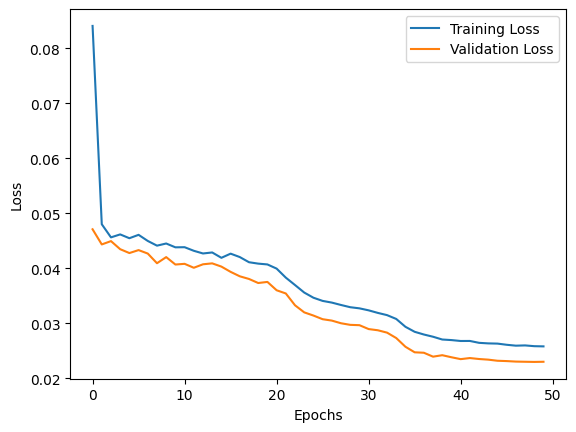

In [ ]:
# Отображение графика ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Использование обученного автокодировщика для восстановления изображений
test_image = tf.keras.preprocessing.image.load_img('/content/selector/test/app002prod (11).jpeg', target_size=(128, 128))
test_image = tf.keras.preprocessing.image.img_to_array(test_image) / 255.0
test_image = tf.expand_dims(test_image, axis=0)
decoded_image = vae.predict(test_image)

1/1 [==============================] - 0s 55ms/step


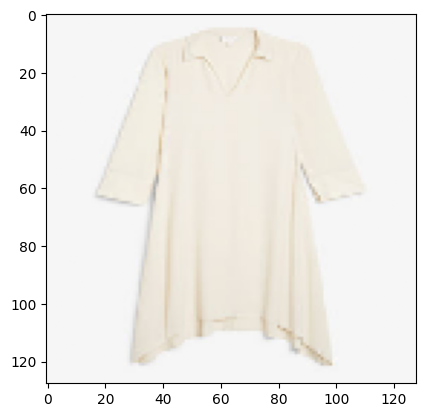

In [ ]:
# Вывод исходного изображения
plt.imshow(test_image.numpy().reshape(128, 128, 3))
# Показать графики
plt.show()

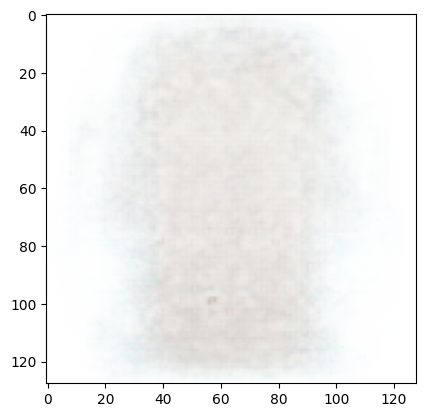

In [ ]:
# Вывод полученного изображения
plt.imshow(decoded_image.reshape(128, 128, 3))

# Показать графики
plt.show()

# **Далее пройдусь по каждому виду одежды**